In [1]:
# Function to take a folder path, load the behavioral and licking data. Clean it to a nice lil pandas df
def load_beh_data(path, animal_id):

    import os 
    import pandas as pd
    import numpy as np

    file_pandas = animal_id + "_df.csv"
    if os.path.isfile(file_pandas):
        beh_df = pd.read_csv(file_pandas)
    else:
    
        file_data = 'analyze_animal_'+animal_id+'.mat'
        data_path = os.path.join(path,file_data)

        beh_data = import_matlab_file(data_path)
        beh_df, ignore = pd_from_uneven_dict(beh_data['animal'])
        beh_df = beh_df.rename(columns={"lick_0": "RH", "lick_1": "LH", "lick_2": "RM", "lick_3": "LM", "lick_4": "NG"})

        boo_cols = ["RH", "LH", "RM", "LM", "NG", "LED"]
        beh_df[boo_cols] = beh_df[boo_cols].astype(bool)


        file_ttl = 'ttl_info_'+animal_id+'.mat'
        ttl_path = os.path.join(path, file_ttl)
        ttl_data = import_matlab_file(ttl_path)

        beh_df['Spout_1']= np.mean(ttl_data['trial_info']['lick'][:,750:825,0],axis = 1)
        beh_df['Spout_2'] = np.mean(ttl_data['trial_info']['lick'][:,750:825,1],axis = 1)


        file_ttl2 = 'ttl_choices_'+animal_id+'.mat'
        ttl_path2 = os.path.join(path, file_ttl2)
        ttl_data2 = import_matlab_file(ttl_path2)
        c = ttl_data2['trial_info']['choice'][:,:,750:1750]
        beh_df['latency'] = determine_latency(beh_df['rxnTime'], c)

        beh_df.to_csv(file_pandas, index= False)
        

    return beh_df

In [2]:
# Function that infers the latency of a response from the lick rasters
def determine_latency(rxn, c):
    import numpy as np
    rx = []
    for a in range(c.shape[0]):
        r = (np.argwhere(c[a,:,:]== 1))

        if r.size == 0 and rxn[a] > 0:
            rx.append(rxn[a]);
        elif r.size == 0:
            rx.append(np.nan)
            #ch.append(np.nan)
        else:
            #ch.append(r[0][0])
            rx.append(r[0][1])

    return rx

In [3]:
def import_matlab_file(file):
    from scipy.io import loadmat
    
    mat_data = loadmat(file, struct_as_record = False, squeeze_me = True, mat_dtype = True, chars_as_strings = True, simplify_cells = True)
    mat_data =  {k:v for k,v in mat_data.items() if '__' not in k};
    
    return mat_data

In [4]:
# Reorganization of dictionaries into dataframes. Used to clean up my matlab structs into df with rows corresponding to trials
def pd_from_uneven_dict(d):

    import numpy as np
    import pandas as pd
    
    shapes = [v.shape for v in d.values() if len(v.shape) == 1]
    trials = max(shapes)[0]

    single_dim = {k:v for k,v in d.items() if (len(v.shape) == 1)  & (trials == v.shape[0])};
    df = pd.DataFrame(single_dim);

    remainder = {};

    for k,v in d.items():
        
        if len(v.shape)  ==  3:
            split_data = np.dsplit(v, v.shape[2]);
            for ind, dim in enumerate(split_data):
                col_name = k + "_"+f'{ind}';
                if dim.shape[0] == trials:
                    df[col_name] = list(np.squeeze(dim))
                else:
                    df[col_name] = list(np.squeeze(dim.transpose))
        elif len(v.shape) == 2:
            if v.shape[1] == trials:
                v = v.transpose()

            if v.shape[1] < 10:
                for i, j in enumerate(v.transpose()):
                        col_name = k + "_" + f'{i}'
                        
                        df[col_name] = j
            else:
                col_name = k
                df[col_name] = list(np.squeeze(v))
                
        elif (len(v.shape) == 1)  & (trials != v.shape[0]):
            remainder[k] = v;

        
            
    return df, remainder

In [5]:
# function to take beh_df and processes the data into the form for modeling. Keep as a dataframe to 
# allow for easier subsampling of trials. Next steps: incorporate a function that allows for easy sampling
# of trial history
def clean_beh_data(b):
    import numpy as np
    import pandas as pd

    
    b2 = pd.DataFrame()
    ns = np.array(np.append(1, np.diff(b['sessionNum'])), dtype = bool)

    b2['Rightward'] = (b['RH'] | b['LM']).astype(int)
    pr = np.concatenate(([0], b2['Rightward'][:-1].values));
    pr[ns] = 0;
    b2['Previous_rightward'] = pr;

    b2['Correct'] = (b['RH'] | b['LH']).astype(int)
    pc = np.concatenate(([0], b2['Correct'][:-1].values))  
    pc[ns] = 0;
    b2['Previous_correct'] = pc;

    b2['Stimulus'] =np.log2(b['stimulus']/8)/2
    #b2['Stimulus'] =(1/b['stimulus'])
    b2['LED'] = b['LED'].astype(int);
    b2['Target'] = b['target'].astype(int);
    b2['Session'] = b['sessionNum'];

   
    b2['Latency'] = np.log2((1/(b['latency'])*1000)/8)/2;
    #b2['New_session']= ns;
   
    go = ((b['RH'] | b['LM'] | b['RM'] | b['LH']).values) & ((b['latency'] > 0).T).values
    b2 = b2.iloc[go,:]
    
    return b2

In [6]:
def expand_history(d, back):
    import numpy as np
    d = np.expand_dims(d, axis = 1)

    for _ in range(back):
        add = np.r_[0, d[:-1, -1]]
        d = np.c_[d, add]

    return d


In [210]:
import os
path = os.getcwd();

animal = 'opto_207'

#path = r"C:\Users\natet\Desktop\Experimental_Data\IT\opto_204"
import numpy as np

b = load_beh_data(path, animal)
b2 = clean_beh_data(b)
b2.head()

,Rightward,Previous_rightward,Correct,Previous_correct,Stimulus,LED,Target,Session,Latency
155,0,0,1,0,-1.0,0,0,1.0,-1.312401
157,0,0,1,0,1.0,0,0,1.0,-1.127901
158,0,0,1,1,-1.0,0,0,1.0,-0.599561
159,0,0,1,1,1.0,0,0,1.0,-1.456899
160,0,0,1,1,-1.0,0,0,1.0,-0.833605


In [228]:

#inputs = ['Previous_rightward', 'Previous_correct', 'Stimulus', 'Latency']
#dat = np.array(b2[inputs])
#d = np.array(b2['Previous_correct'])

previous_choice = expand_history(np.array(b2['Previous_rightward']), 1)
previous_reward = expand_history(np.array(b2['Previous_correct']),1)
previous_stimulus = expand_history(np.array(b2['Stimulus']),2)
#inputs = ['Previous_correct', 'Stimulus', 'Latency']
latency = np.array(b2['Latency'])

X = np.c_[np.ones((latency.shape[0], 1)), previous_stimulus, previous_choice, previous_reward, latency]
y = b2['Rightward']
labels = ['Bias', 'Stimulus', '1 Stim', '2 Stim', '1 Choice', '2 Choice', '1 Reward', '2 Reward', 'latency']

In [229]:
X1 = X[b2['LED'].astype(bool) & b2['Stimulus'] != 0,:]
X2 = X[~b2['LED'].astype(bool) & b2['Stimulus'] != 0,:]
X3 = X[b2['Stimulus'] == 0,:]
y1 = y[b2['LED'].astype(bool) & b2['Stimulus'] != 0]
y2 = y[~b2['LED'].astype(bool) & b2['Stimulus'] != 0]
y3 = y[ b2['Stimulus'] == 0]


#X1 = X[b2['LED'].astype(bool) ,:]
#X2 = X[~b2['LED'].astype(bool) ,:]
#y1 = y[b2['LED'].astype(bool) ]
#y2 = y[~b2['LED'].astype(bool) ]

In [230]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.33)
from sklearn.linear_model import LogisticRegressionCV
clf1 = LogisticRegressionCV(cv=5, random_state=0).fit(X1_train, y1_train)
clf2 = LogisticRegressionCV(cv=5, random_state=0).fit(X2_train, y2_train)
clf3 = LogisticRegressionCV(cv=5, random_state=0).fit(X3_train, y3_train)



In [231]:
print(clf1.score(X1_test,y1_test))
print(clf2.score(X2_test,y2_test))
print(clf3.score(X3_test,y3_test))

0.6352657004830918
0.5978593272171254
0.7284595300261096


In [232]:
X1.shape
np.arange(X.shape[1])

array([0, 1, 2, 3, 4, 5, 6, 7])

Text(0.5, 1.0, '8 Hz')

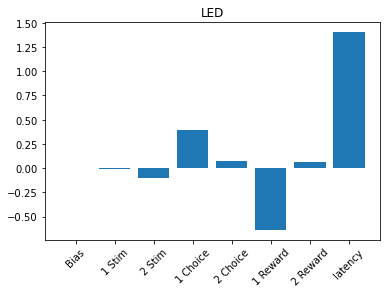

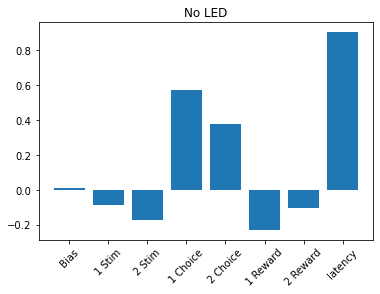

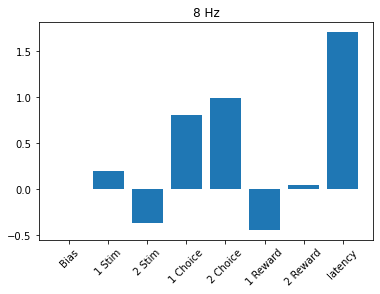

In [233]:
import matplotlib.pyplot as plt
x = np.arange(len(labels)) 

fig, ax = plt.subplots()
ax.bar(x, clf1.coef_[0])
plt.xticks(x,rotation = 45)
ax.set_xticklabels(labels)
plt.title('LED')

clf1.score(X1_test, y1_test)

fig, ax = plt.subplots()
ax.bar(x, clf2.coef_[0])
plt.xticks(x,rotation = 45)
ax.set_xticklabels(labels)
clf2.score(X2_test, y2_test)
plt.title('No LED')

fig, ax = plt.subplots()
ax.bar(x, clf3.coef_[0])
plt.xticks(x,rotation = 45)
ax.set_xticklabels(labels)
clf3.score(X3_test, y3_test)
plt.title('8 Hz')
#  LED

0.8132201334141904

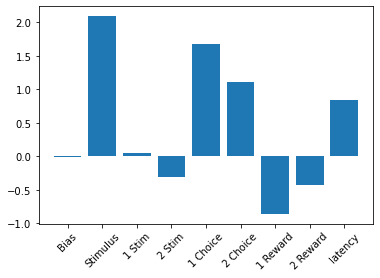

In [195]:
fig, ax = plt.subplots()
ax.bar(x, clf2.coef_[0])
plt.xticks(x,rotation = 45)
ax.set_xticklabels(labels)
clf2.score(X2_test, y2_test)
# no LED

0.7893462469733656

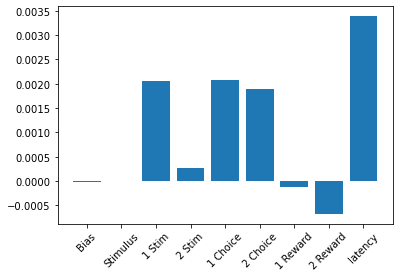

In [139]:
fig, ax = plt.subplots()
ax.bar(x, clf3.coef_[0])
plt.xticks(x,rotation = 45)
ax.set_xticklabels(labels)
clf3.score(X3_test, y3_test)

In [183]:
y_train

10799    0
8138     0
6116     1
4144     0
2569     1
        ..
4872     0
6478     0
7067     1
3239     1
8662     0
Name: Rightward, Length: 982, dtype: int64

AttributeError: module 'matplotlib' has no attribute '__version___'

To do list:
- decide on data input i.e. what stages of training to run analysis on
- write code to iteratively fit each animal by walking through the directories
- EVALUATE THE FITS - ensure the regression is actually fitting the data 

Tasks
- function to generate the inputs to the model
- function to split the data into groups of interest (i.e. LED, no LED, 8 Hz)
- function to run the model, generate score, return coefficients
- second function to run leave on out with each parameter with BIC to determine which weight is most important for the fit
- function to 